In [117]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import cv2
from PIL import Image

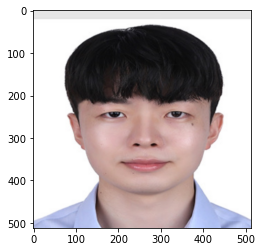

In [118]:
contents = cv2.imread('contents.jpg')
contents = cv2.resize(contents, (512,512))
plt.imshow(cv2.cvtColor(contents, cv2.COLOR_BGR2RGB))

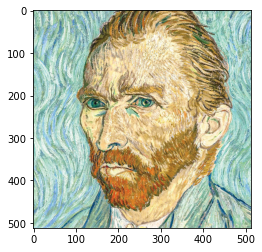

In [119]:
style = cv2.imread('style.jpg') 
style = cv2.resize(style,(512,512))
plt.imshow(cv2.cvtColor(style, cv2.COLOR_BGR2RGB))

In [120]:
vgg_model = tf.keras.applications.VGG16(input_shape=(512,512,3),
                                        include_top = False,
                                        weights = 'imagenet')
vgg_model.trainable = False


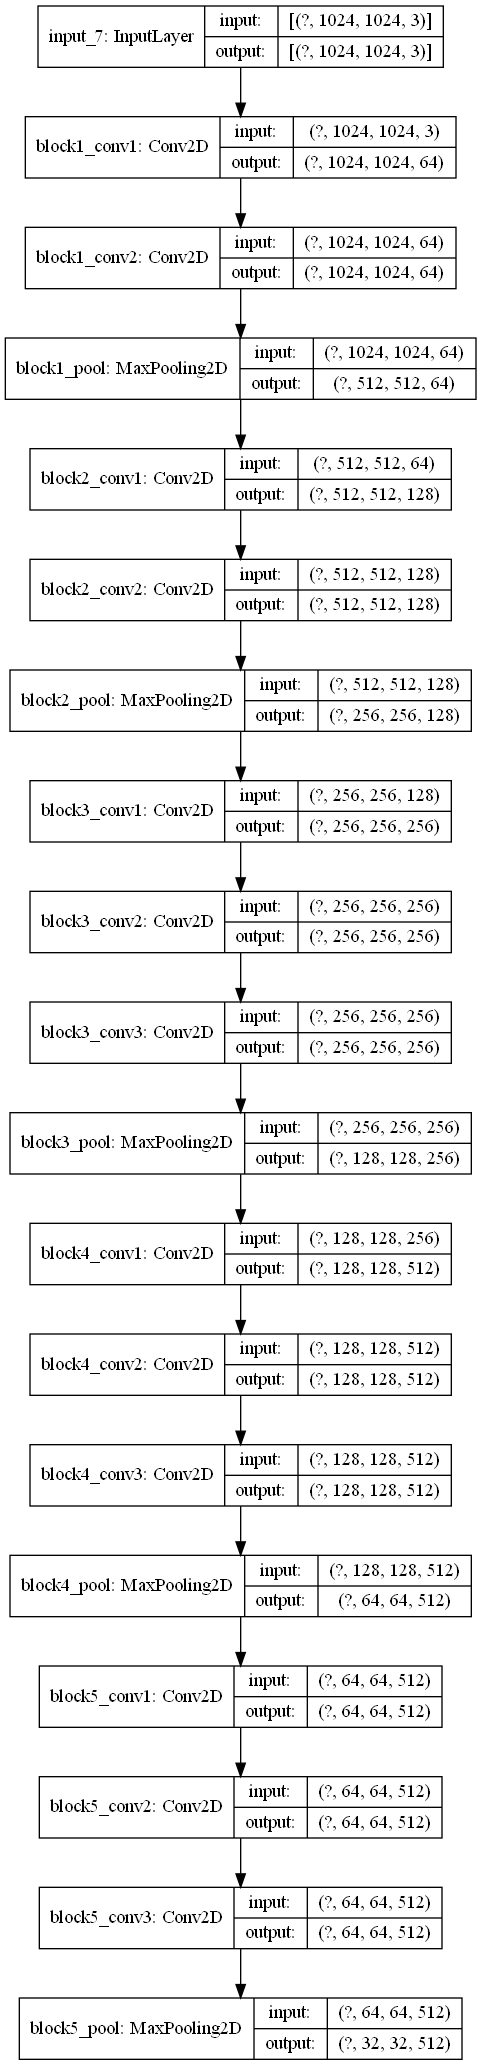

In [93]:
tf.keras.utils.plot_model(vgg_model, show_shapes =True)

In [94]:
#VGG16에서 style transfer를 위한 중간 출력층을 가져오기

In [121]:
style_transfer_model = tf.keras.Model(inputs = [vgg_model.input],
                                      outputs = [
                                          vgg_model.get_layer(name = 'block1_conv2').output,
                                          vgg_model.get_layer(name = 'block2_conv2').output,
                                          vgg_model.get_layer(name = 'block3_conv3').output,
                                          vgg_model.get_layer(name = 'block4_conv3').output
                                      ])
style_transfer_model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0  

### 스타일 특성맵 추출

In [122]:
style_true_b1c1,style_true_b2c2, style_true_b3c3, style_true_b4c3 = style_transfer_model.predict(np.reshape(style,(-1,512,512,3)))

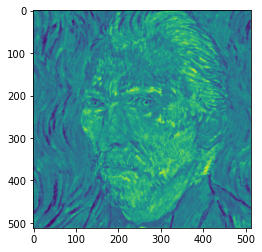

In [123]:
plt.imshow(style_true_b1c1[0][:,:,60])

#### content Loss의 ground True값

In [124]:
contents_true_b1c1, contents_true_b2c2, contents_true_b3c3, contents_true_b4c3 = style_transfer_model.predict(np.reshape(contents, (-1,512,512,3)))
contents_true_b4c3.shape

(1, 64, 64, 512)

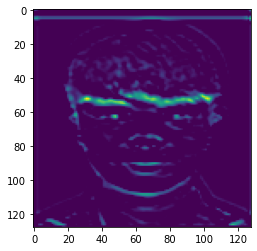

In [125]:
#추출한 특성맵 시각화
plt.imshow(contents_true_b3c3[0][:,:,250])

In [126]:
def Gram_matrix(x):
    reshape_x = tf.transpose(x, [2,1,0])
    s= tf.shape(reshape_x)
    reshape_x = tf.reshape(reshape_x, (s[0], s[1]*s[2]))
    reshape_x_t = tf.transpose(reshape_x)
    dot = tf.matmul(reshape_x,reshape_x_t)
    dot = tf.cast(dot,dtype='float32')
    dot = dot/tf.cast(tf.shape(reshape_x)[0],tf.float32)/tf.cast(tf.shape(reshape_x)[1],tf.float32)
    return dot
Gram_matrix(contents_true_b3c3[0])

<tf.Tensor: shape=(256, 256), dtype=float32, numpy=
array([[ 17.963623 ,   5.052613 ,   9.886554 , ...,  12.671154 ,
          1.5442764,  13.648189 ],
       [  5.052613 , 125.92151  ,  75.634766 , ...,  67.64932  ,
         14.736787 ,  16.67157  ],
       [  9.886554 ,  75.634766 , 549.1661   , ..., 138.77739  ,
          7.9368463,  49.874317 ],
       ...,
       [ 12.671154 ,  67.64932  , 138.77739  , ..., 408.86133  ,
         22.860369 ,  70.51296  ],
       [  1.5442764,  14.736787 ,   7.9368463, ...,  22.860369 ,
         54.19801  ,  31.604641 ],
       [ 13.648189 ,  16.67157  ,  49.874317 , ...,  70.51296  ,
         31.604641 , 335.16312  ]], dtype=float32)>

In [127]:
#스타일 지정을 위한 input_image지정
input_image = cv2.imread('contents.jpg')
input_image = cv2.resize(input_image, (512,512))


1
s_loss tf.Tensor(3359541.8, shape=(), dtype=float32)
c_loss tf.Tensor(0.0, shape=(), dtype=float32)

2
s_loss tf.Tensor(2935484.5, shape=(), dtype=float32)
c_loss tf.Tensor(10798.962, shape=(), dtype=float32)

3
s_loss tf.Tensor(2496572.8, shape=(), dtype=float32)
c_loss tf.Tensor(30065.785, shape=(), dtype=float32)

4
s_loss tf.Tensor(2052365.8, shape=(), dtype=float32)
c_loss tf.Tensor(51634.04, shape=(), dtype=float32)

5
s_loss tf.Tensor(1749426.0, shape=(), dtype=float32)
c_loss tf.Tensor(64495.637, shape=(), dtype=float32)

6
s_loss tf.Tensor(1459384.8, shape=(), dtype=float32)
c_loss tf.Tensor(76269.4, shape=(), dtype=float32)

7
s_loss tf.Tensor(1192564.8, shape=(), dtype=float32)
c_loss tf.Tensor(88264.58, shape=(), dtype=float32)

8
s_loss tf.Tensor(960654.94, shape=(), dtype=float32)
c_loss tf.Tensor(100705.16, shape=(), dtype=float32)

9
s_loss tf.Tensor(767699.1, shape=(), dtype=float32)
c_loss tf.Tensor(113810.65, shape=(), dtype=float32)

10
s_loss tf.Tensor(611155.25

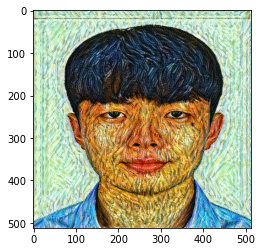

In [128]:
img_avi = np.zeros((224,224,3))
opt = tf.keras.optimizers.Adam(5.0)#이미지 변환 속도를 위해 이렇게 높게 책정한다고함
fcc = cv2.VideoWriter_fourcc(*'DIVX')
out =  cv2.VideoWriter('styel_transfer.avi', fcc, 10.0, (512,512))
for epoch in range(200):
    input_image = tf.reshape(input_image,(-1,512,512,3))
    input_image = tf.cast(input_image, dtype='float32')
    input_image = tf.Variable(input_image, dtype=tf.float32)
    with tf.GradientTape() as tape:
        b1c1, b2c2, b3c3, b4c3 = style_transfer_model(input_image)
        s_loss_1 = tf.stop_gradient(Gram_matrix(style_true_b1c1[0])) - Gram_matrix(b1c1[0])
        s_loss_1 = tf.reduce_mean(tf.square(s_loss_1))
        s_loss_2 = tf.stop_gradient(Gram_matrix(style_true_b2c2[0])) - Gram_matrix(b2c2[0])
        s_loss_2 = tf.reduce_mean(s_loss_2 *  s_loss_2)
        s_loss_3 = tf.stop_gradient(Gram_matrix(style_true_b3c3[0])) - Gram_matrix(b3c3[0])
        s_loss_3 = tf.reduce_mean(s_loss_3 *  s_loss_3)
        s_loss_4 = tf.stop_gradient(Gram_matrix(style_true_b4c3[0])) - Gram_matrix(b4c3[0])
        s_loss_4 = tf.reduce_mean(s_loss_4 *  s_loss_4)
        
        c_loss_1 = contents_true_b1c1 - b1c1
        c_loss_1 = tf.reduce_mean(tf.square(c_loss_1))
        c_loss_2 = contents_true_b2c2 - b2c2
        c_loss_2 = tf.reduce_mean(tf.square(c_loss_2))
        c_loss_3 = contents_true_b3c3 - b3c3
        c_loss_3 = tf.reduce_mean(tf.square(c_loss_3))
        c_loss_4 = contents_true_b4c3 - b4c3
        c_loss_4 = tf.reduce_mean(tf.square(c_loss_4))
        
        s_loss = (s_loss_1 + s_loss_2 + s_loss_3 + s_loss_4)
        c_loss = (c_loss_1 + c_loss_2 + c_loss_3 + c_loss_4)/4.
        loss = s_loss*10.0+c_loss_3 #style loss와 content loss의 가중합의 적용
    grad = tape.gradient(loss,input_image)
    opt.apply_gradients([(grad, input_image)]) 
    input_image = tf.cast(input_image, dtype = tf.int32)
    input_image = tf.clip_by_value(input_image,0,255) 
    img_avi = input_image.numpy()[0]
    if((epoch+0)%10 == 0):
        cv2.imwrite('{}.jpg'.format(epoch),img_avi)
    out.write(np.uint8(img_avi))
    print()
    print(epoch+1)
    print('s_loss', s_loss)
    print('c_loss', c_loss)
plt.imshow(input_image[0][:,:,::-1])
out.release()
cv2.destroyAllWindows()     